# 3.2. Single frame training (tg.common.ml.single_frame_training)

## Overview of the training process

Training Grounds offers the "training as an object" concept. Instead of "just" writing down the code that is required to train the model, this code is incapsulated in several classes with strong adherence to the SOLID principles. Each class performs the well-defined stage of the process, like splitting dataset into test and train subsets, providing metrics, etc.

The advantages of this approach are:
* Reusability of the most components across the projects, so you don't copy-paste the same code over and over again
* Testability of the components, so you know that you can rely to the components (at least to the part of their functionality that has been tested)

The disadvantage is:
* The onboarding time increases, because "just writing down the code" is a dominating way of teaching data science
* The approach may feel not flexible enough at the start. 

In this model, the training is an object, which is composition of other objects. This object can then be packaged as a Python package, installed in the Docker container and delivered elsewhere, e.g. to Sagemaker. 

## If you don't want all this

... That's also fine. TG is designed to make the life easier, not worse. We offer the SOLID implementation for two wide-spread training scenarios, and we believe that this is a generally better way. But if you are uncomfortable with the SOLID approach to training, or your training process is so specific that it does not fit into both scenarios we have implemented, you always have the following option:

* Inherit from `AbstractTrainingTask`
* Implement `run` method and write the code in any way you see appropriate
* Consider implementing `get_metric_names`, as the metric names must be available prior to the training's start in Sagemaker. You can always return empty array. 

After this, you code will be deliverable with TG delivery. You may also alter the delivery process, as it was explained in the corresponding part of the demo.


## Overview of single-frame training process

Single-frame training process is the process where:
* All data for training fits the memory of the training instance. 
* All training is executed within a single run to `fit` method

These requirements are usually in place for `sklearn` models and alikes. Neural networks require different approach which will be described in the next demo.

## Minimal working example

The single-frame training is represented by `SingleFrameTrainingTask`. To configure it, you may use quite a lot of arguments, so let's go step-by-step and create a minimal working training task.

First, let's load the dataset.

In [1]:
import pandas as pd

df = pd.read_csv('titanic.csv')
df = df.set_index('PassengerId')
for c in ['Pclass','SibSp','Parch','Survived']:
    df[c] = df[c].astype(float)
    
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S
2,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C
3,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
5,0.0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,S


Let's now define the dataframe with features and labels:

In [2]:
import tg.common.ml.dft as dft

tfac = dft.DataFrameTransformerFactory.default_factory(
    features = [feature for feature in df.columns if feature not in ['Survived','Name','Ticket']],
    max_values_per_category=10
)

tdf = tfac.fit_transform(df)
tdf['Survived'] = df['Survived']
tdf.head()

,Pclass,Age,SibSp,Parch,Fare,Age_missing,Sex_male,Sex_female,Cabin_C23 C25 C27,Cabin_G6,...,Cabin_E101,Cabin_F33,Cabin_D,Cabin_OTHER,Cabin_NULL,Embarked_S,Embarked_C,Embarked_Q,Embarked_NULL,Survived
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.827377,-0.530377,0.432793,-0.473674,-0.502445,False,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,-1.566107,0.571831,0.432793,-0.473674,0.786845,False,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.827377,-0.254825,-0.474545,-0.473674,-0.488854,False,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,-1.566107,0.365167,0.432793,-0.473674,0.420730,False,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5,0.827377,0.365167,-0.474545,-0.473674,-0.486337,False,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Now, we are ready to build and run the very simple training task

In [3]:
import tg.common.ml.single_frame_training as sft

task = sft.SingleFrameTrainingTask(
    data_loader = sft.DataFrameLoader('Survived'),
    model_provider = sft.ModelProvider(sft.ModelConstructor('sklearn.linear_model:LogisticRegression')),
    evaluator = sft.Evaluation.binary_classification
)

result = task.run(tdf)

  0%|          | 0/1 [00:00<?, ?it/s]

2022-06-28 13:14:50.711459+00:00 INFO: Starting stage 1/1
2022-06-28 13:14:50.761729+00:00 INFO: Completed stage 1/1


Essential components are:

`DataFrameLoader`, which processes pandas data frame into `DataFrameSplit`, containing information about features, labels and splits used for training.

`ModelProvider`, which generates a model. Why do we use a string representation of the class instead of class itself? The reason for that is that the model we use can be a hyperparameter, and this way we can tune the class of the model in the same way as other hyperparameters.

`Evaluation`. This is a function that interprets the output of the model (which is a numpy array) into a dataframe.

As we see, the training produces messages in `Logger`. This is very useful when monitoring the training in Sagemaker, however, does not help much in this notebook, so we will disable `Logger`.

In [4]:
from tg.common import Logger

Logger.disable()

The result is a dictionary that contains all information about the training, for intance, model itself:

In [5]:
result['runs'][0]['model']

Pipeline(steps=[('ColumnNamesKeeper', ColumnNamesKeeper()),
                ('Model', LogisticRegression())])

Note that the model is a pipeline of two steps.

The first step of the pipeline is a decorator that keeps the column names of the original dataset. It is mostly for double-checking, so when you use the model in production you can check if all the columns are present. You can disable adding this with a parameter of `ModelProvider`, but we recommend to let it be.

The second step is a model, specified by a `ModelProvider`.

Also, the result contains the dataframe, created by `Evaluation`. This table is useful to compute various metrics:

In [6]:
result['runs'][0]['result_df'].head()

,predicted,true,stage,original_index
PassengerId,,,,
1,0.096888,0.0,train,1
2,0.938098,1.0,train,2
3,0.649651,1.0,train,3
4,0.916243,1.0,train,4
5,0.080957,0.0,train,5


## Spliters

In the previous step we trained model on all the available data, and then applied the model to this training data, without having a test set. To change that, we need to use splitter.

In [7]:
import tg.common.ml.single_frame_training as sft

task = sft.SingleFrameTrainingTask(
    data_loader = sft.DataFrameLoader('Survived'),
    model_provider = sft.ModelProvider(sft.ModelConstructor('sklearn.linear_model:LogisticRegression')),
    evaluator = sft.Evaluation.binary_classification,
    splitter = sft.FoldSplitter(fold_count=5)
)

result = task.run(tdf)

  0%|          | 0/5 [00:00<?, ?it/s]

Now, the result will have 5 runs (one run for each split). Let's check that we have some tests in each run, and that the rows are different for different runs

In [8]:
for run in result['runs'].values():
    rdf = run['result_df']
    rdf = rdf.loc[rdf.stage=='test']
    print(rdf.shape[0], list(rdf.sort_index().index[:5]))

268 [2, 3, 6, 9, 11]
268 [1, 3, 4, 7, 9]
268 [2, 3, 5, 8, 11]
268 [4, 5, 6, 11, 15]
268 [12, 14, 18, 34, 35]


We implemented basic K-fold split. By using other parameters of `FoldSplitter`, or combining several `FoldSplitter` by `UnionSplitter` and `CompositionSplitter`, you can achive more complicated configurations with e.g. holdout test set. Proper splitting of the dataset is extremely important to prevent data leak, so we suggest you will think the split architecture through, and maybe even add your own splitters.

For instance, when analyzing time-dependent data, we find `TimeSplitter` to extremely useful. This splitter forms splits by time. Assume $T_0$ is the time when our data start, $\Delta$ is a step (i.e. one month). In this case, `TimeSplitter` will create the following splits:

* train on $[T_0, T_0+\Delta]$, test on $[T_0+\Delta, T_0+2\Delta]$
* train on $[T_0, T_0+2\Delta]$, test on $[T_0+2\Delta, T_0+3\Delta]$
* train on $[T_0, T_0+3\Delta]$, test on $[T_0+3\Delta, T_0+4\Delta]$
* etc



To uncover a bit what the split is actually doing, let's run it manually:

In [9]:
initial_split = sft.DataFrameLoader('Survived').get_data(tdf)
splits = sft.FoldSplitter(5)(initial_split)
split_repr = splits[0].__dict__
del split_repr['df']
split_repr

{'features': ['Pclass',
  'Age',
  'SibSp',
  'Parch',
  'Fare',
  'Age_missing',
  'Sex_male',
  'Sex_female',
  'Cabin_C23 C25 C27',
  'Cabin_G6',
  'Cabin_B96 B98',
  'Cabin_F2',
  'Cabin_C22 C26',
  'Cabin_E101',
  'Cabin_F33',
  'Cabin_D',
  'Cabin_OTHER',
  'Cabin_NULL',
  'Embarked_S',
  'Embarked_C',
  'Embarked_Q',
  'Embarked_NULL'],
 'labels': 'Survived',
 'train': Int64Index([  1,   4,   5,   7,   8,  10,  12,  13,  14,  16,
             ...
             874, 875, 877, 880, 882, 885, 886, 887, 889, 890],
            dtype='int64', name='PassengerId', length=623),
 'tests': {'test': Int64Index([  2,   3,   6,   9,  11,  15,  19,  21,  28,  31,
              ...
              849, 853, 876, 878, 879, 881, 883, 884, 888, 891],
             dtype='int64', name='PassengerId', length=268)},
 'info': {'test': {'fold': 0, 'index': 0, 'split_column': 'index'}}}

The `DataFrameSplit` object has and `features`, `labels` fields inherited from the `initial_split`. It also inherits `df`, but we have removed it from output for readability. `train` is the array of indices for which train is performed, and `tests` is a dictionary of indices belonging to the one or more test sets (e.g. validation and holdout). Essentially, all splitters form these two fields, `train` and `tests`.

## Transformers



The previous example is actually very flawed. Note that transformer is applied to _all_ the data, while it has to be applied to the training data only. So there is a data leak in this example via the transformer, and this should not happen. This is why we **strongly** encourage you to make transformer a part of the model:

In [10]:
import tg.common.ml.single_frame_training as sft

task = sft.SingleFrameTrainingTask(
    data_loader = sft.DataFrameLoader('Survived'),
    model_provider = sft.ModelProvider(
        constructor = sft.ModelConstructor('sklearn.linear_model:LogisticRegression'),
        transformer = tfac),
    evaluator = sft.Evaluation.binary_classification,
    splitter = sft.FoldSplitter(fold_count=5)
)

result = task.run(df)

  0%|          | 0/5 [00:00<?, ?it/s]

If we now look at the result:

In [11]:
result['runs'][0]['model']

Pipeline(steps=[('ColumnNamesKeeper', ColumnNamesKeeper()),
                ('Transformer',
                 <tg.common.ml.dft.transform_factory.DataFrameTransformerFactory object at 0x7fd59ad4d280>),
                ('ColumnNamesKeeperAfterTransformation', ColumnNamesKeeper()),
                ('Model', LogisticRegression())])

We see that now 2 more steps are added to the pipeline. The first is our `DataFrameTransformerFactory`, which acts as a transformer. The second is yet another instance of ColumnNamesKeeper(), which allows us to track the column names even after transformation

In [12]:
print(result['runs'][0]['model'][0].column_names_)
print(result['runs'][0]['model'][2].column_names_)

['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_missing', 'Sex_male', 'Sex_female', 'Cabin_C23 C25 C27', 'Cabin_E101', 'Cabin_B96 B98', 'Cabin_C22 C26', 'Cabin_D', 'Cabin_C93', 'Cabin_C123', 'Cabin_D33', 'Cabin_OTHER', 'Cabin_NULL', 'Embarked_S', 'Embarked_C', 'Embarked_Q', 'Embarked_NULL']


## Metrics

You can use `MetricsPool` to measure the training success:

In [13]:
import tg.common.ml.single_frame_training as sft
from sklearn.metrics import roc_auc_score

task = sft.SingleFrameTrainingTask(
    data_loader = sft.DataFrameLoader('Survived'),
    model_provider = sft.ModelProvider(
        constructor = sft.ModelConstructor('sklearn.linear_model:LogisticRegression'),
        transformer = tfac),
    evaluator = sft.Evaluation.binary_classification,
    splitter = sft.FoldSplitter(fold_count=5),
    metrics_pool = sft.MetricPool().add_sklearn(roc_auc_score)
)

result = task.run(df)

  0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
from yo_fluq_ds import Query

pd.DataFrame([run['metrics'] for run in result['runs'].values()])

,roc_auc_score_test,roc_auc_score_train
0,0.856012,0.863213
1,0.825860,0.877670
2,0.831626,0.875503
3,0.823640,0.877365
4,0.876280,0.855036


Note: since `sft.Evaluation.binary_classification` actually uses `predict_proba` instead of `predict`, f1, precision and recall scores cannot be used with it. The best way around it is using custom metric. Note that you can combine several metrics into one `Metric` instance:

In [15]:
import tg.common.ml.single_frame_training as sft
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

class MetricsWithBorderline(sft.Metric):
    def __init__(self, borderline=0.5):
        self.borderline = borderline
    def get_names(self):
        return ["f1","precision","recall"]
    def measure(self, result_df: pd.DataFrame, source_data):
        prediction = result_df.predicted>self.borderline
        return [
            f1_score(result_df.true, prediction),
            precision_score(result_df.true, prediction),
            recall_score(result_df.true, prediction)
        ]
            
    

task = sft.SingleFrameTrainingTask(
    data_loader = sft.DataFrameLoader('Survived'),
    model_provider = sft.ModelProvider(
        constructor = sft.ModelConstructor('sklearn.linear_model:LogisticRegression'),
        transformer = tfac),
    evaluator = sft.Evaluation.binary_classification,
    splitter = sft.FoldSplitter(fold_count=5),
    metrics_pool = sft.MetricPool().add_sklearn(roc_auc_score).add(MetricsWithBorderline()),
)

result = task.run(df)

pd.DataFrame([run['metrics'] for run in result['runs'].values()])

  0%|          | 0/5 [00:00<?, ?it/s]

,roc_auc_score_test,f1_test,precision_test,recall_test,roc_auc_score_train,f1_train,precision_train,recall_train
0,0.856012,0.734694,0.750000,0.720000,0.863213,0.736383,0.778802,0.698347
1,0.825860,0.746544,0.794118,0.704348,0.877670,0.736364,0.760563,0.713656
2,0.831626,0.706468,0.763441,0.657407,0.875503,0.738938,0.766055,0.713675
3,0.823640,0.720379,0.710280,0.730769,0.877365,0.747253,0.783410,0.714286
4,0.876280,0.727273,0.744186,0.711111,0.855036,0.738776,0.760504,0.718254


As you can see, `Metric::measure` accepts not only resulting dataframe (which is essentialy output of the evaluator), but also the source data used for training, so you can weight different instances based on their importance, etc.

## Using other classifiers

Needless to say, the whole system works not only with logistic regression, but also with any other `sklearn` algorithm, such as XGBoost or random forests

In [16]:
import tg.common.ml.single_frame_training as sft
from sklearn.metrics import roc_auc_score, f1_score

task = sft.SingleFrameTrainingTask(
    data_loader = sft.DataFrameLoader('Survived'),
    model_provider = sft.ModelProvider(
        constructor = sft.ModelConstructor('sklearn.ensemble:RandomForestClassifier'),
        transformer = tfac),
    evaluator = sft.Evaluation.binary_classification,
    splitter = sft.FoldSplitter(fold_count=5),
    metrics_pool = sft.MetricPool().add_sklearn(roc_auc_score),
)

result = task.run(df)

pd.DataFrame([run['metrics'] for run in result['runs'].values()])

  0%|          | 0/5 [00:00<?, ?it/s]

,roc_auc_score_test,roc_auc_score_train
0,0.871012,0.998276
1,0.834697,0.998949
2,0.847946,0.997391
3,0.825311,0.999574
4,0.879245,0.997882


## Using catboost

`catboost` is a powerful algorithm, based on decision tree, which works particularly well on datasets with lots of categorical variables. We admit that the true reason why we pay specific attention to this algorithm is because the major contributor to TG is Russian, and the `catboost` was also developed in Russia, and widespread in the data science circles there. 

There are two moments about this algorithm.

First, `catboost` doesn't require you to apply OneHot encoding, so we will exclude this step from `tfac`. It will also reduce the memory, required for the training. However, **be careful with that**! If you don't trim the amount of variables in your categorical columns, there are the great chances that `catboost` will basically build a binary tree of exponential size around these columns, which will make the model huge and slow! `TopKPopularStrategy` actually appeared in code after we discovered this sad fact.

Second, when using `catboost`, there is a little trick to be make. The list of categorical variables must be given to catboost prior training. However, in our architecture, we don't really know which columns are categorical, because it is only known when TransformerFactory processed the dataset. This is why we use a little wrapper to do that.

In [17]:
import tg.common.ml.single_frame_training as sft
from sklearn.metrics import roc_auc_score, f1_score
from functools import partial

catboost_tfac = (dft.DataFrameTransformerFactory()
 .with_feature_block_list(['Survived','Name','Ticket'])
 .on_continuous(dft.ContinousTransformer)
 .on_categorical(dft.CategoricalTransformer)
 .on_rich_category(10, partial(
     dft.CategoricalTransformer, 
     replacement_strategy = dft.TopKPopularStrategy(10,'OTHER')
)))


task = sft.SingleFrameTrainingTask(
    data_loader = sft.DataFrameLoader('Survived'),
    model_provider = sft.ModelProvider(
        constructor = sft.ModelConstructor('catboost:CatBoostClassifier', silent=True),
        transformer = catboost_tfac,
        model_fix = sft.ModelProvider.catboost_model_fix
    ),
    evaluator = sft.Evaluation.binary_classification,
    splitter = sft.FoldSplitter(fold_count=5),
    metrics_pool = sft.MetricPool().add_sklearn(roc_auc_score),
)

result = task.run(df)

pd.DataFrame([run['metrics'] for run in result['runs'].values()])

  0%|          | 0/5 [00:00<?, ?it/s]

,roc_auc_score_test,roc_auc_score_train
0,0.880298,0.931954
1,0.832793,0.935639
2,0.853791,0.942115
3,0.839030,0.941362
4,0.890886,0.921031


Note that we provided some additional arguments to the `ModelConstructor`. This parameter is passed to `CatBoostClassifier` constructor, making it silent. The same works with other models, too.

Now, let's check the trained model:

In [18]:
result['runs'][0]['model']

Pipeline(steps=[('ColumnNamesKeeper', ColumnNamesKeeper()),
                ('Transformer',
                 <tg.common.ml.dft.transform_factory.DataFrameTransformerFactory object at 0x7fd59accea90>),
                ('ColumnNamesKeeperAfterTransformation', ColumnNamesKeeper()),
                ('Model',
                 Pipeline(steps=[('CategoricalVariablesSetter',
                                  <tg.common.ml.single_frame_training.model_provider.CatBoostWrap object at 0x7fd598124280>),
                                 ('Model',
                                  <catboost.core.CatBoostClassifier object at 0x7fd5bdf84f40>)]))])

`model_fix` is a function, that updates the model to something else. In our case, the initial instance of catboost model `Model` was replaced with a Pipeline, containing two steps. The second step is `Model`. The first step is a wrapper, that accepts the dataset, processed by transformers, understands which columns are categorical, and then sets the list of this columns to the `Model`

## Artificiers

_Artificier_ is an interface to inject an arbitrary code to the training process. So far, we had two use cases for artificiers:
* Remove model from the training result. The model may be huge and we may not be even interested in the model per se, just by it's metrics.
* Get the feature significance. Many algorithms allow us to extract feature significance from the model, which can be used in business analysis without the model itself.

Let's use write an artificier to discover the most important features in our dataset. 

In [19]:
import tg.common.ml.single_frame_training as sft
from sklearn.metrics import roc_auc_score

class SignificanceArtificier:
    def run(self, model_info):
        column_names_keeper = model_info.result.model[2] # type: sft.ColumnNamesKeeper
        column_names = column_names_keeper.column_names_
        coeficients = model_info.result.model[3].coef_
        model_info.result.significance = pd.Series(coeficients[0], index=column_names)
        

task = sft.SingleFrameTrainingTask(
    data_loader = sft.DataFrameLoader('Survived'),
    model_provider = sft.ModelProvider(
        constructor = sft.ModelConstructor('sklearn.linear_model:LogisticRegression'),
        transformer = tfac),
    evaluator = sft.Evaluation.binary_classification,
    splitter = sft.FoldSplitter(fold_count=50),
    metrics_pool = sft.MetricPool().add_sklearn(roc_auc_score),
    artificers=[
        SignificanceArtificier()
    ]
)

result = task.run(df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
sdf = pd.DataFrame([run['significance'] for run in result['runs'].values()])
sdf.head()

,Pclass,Age,SibSp,Parch,Fare,Age_missing,Sex_male,Sex_female,Cabin_C23 C25 C27,Cabin_E101,...,Cabin_B77,Cabin_E44,Cabin_C2,Cabin_D20,Cabin_B35,Cabin_F G73,Cabin_B20,Cabin_B18,Cabin_B22,Cabin_C52
0,-0.729712,-0.599334,-0.442507,-0.090442,0.044117,-0.275676,-1.335706,1.334984,0.096968,0.280976,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.827425,-0.629947,-0.350360,0.028300,-0.068819,-0.388938,-1.391383,1.391777,-0.203659,0.239313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.827155,-0.694813,-0.397645,-0.046530,-0.041126,-0.330843,-1.408049,1.410029,-0.007618,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.730623,-0.655058,-0.473254,-0.064541,0.241218,-0.183655,-1.388633,1.388427,-0.074086,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.747540,-0.535634,-0.278574,-0.010801,0.099159,-0.465550,-1.235044,1.235681,-0.270592,0.421581,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Apparently the most popular cabins depend strongly on the split, so we will remove them. After that, we may draw a violinplot demonstrating significance.

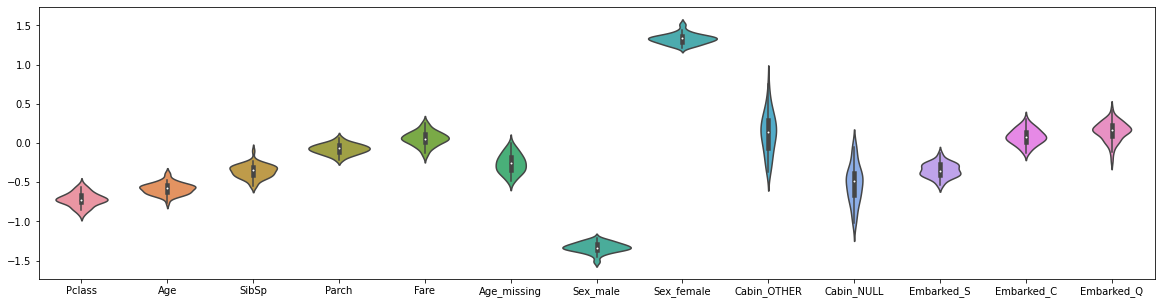

In [21]:
from seaborn import violinplot
from matplotlib import pyplot as plt

bad_columns = sdf.isnull().any(axis=0)
bad_columns = list(bad_columns.loc[bad_columns].index)
cdf = sdf[[c for c in sdf.columns if c not in bad_columns]]

_, ax = plt.subplots(1,1,figsize=(20,5))
violinplot(data=cdf, ax=ax)
pass

## Hyperparameter optimization

Hyperparameter optimization can be performed over *any* field inside the task class. 

In [22]:
task = sft.SingleFrameTrainingTask(
    data_loader = sft.DataFrameLoader('Survived'),
    model_provider = sft.ModelProvider(
        constructor = sft.ModelConstructor('sklearn.linear_model:LogisticRegression'),
        transformer = tfac),
    evaluator = sft.Evaluation.binary_classification,
    splitter = sft.FoldSplitter(fold_count=1),
    metrics_pool = sft.MetricPool().add_sklearn(roc_auc_score)
)
parameters = {
    "model_provider.constructor.kwargs.C" : 1,
    "model_provider.constructor.kwargs.penalty": 'l2',
}
task.apply_hyperparams(parameters)

result = task.run(df)
result['runs'][0]['model']

  0%|          | 0/1 [00:00<?, ?it/s]

Pipeline(steps=[('ColumnNamesKeeper', ColumnNamesKeeper()),
                ('Transformer',
                 <tg.common.ml.dft.transform_factory.DataFrameTransformerFactory object at 0x7fd57c6ce790>),
                ('ColumnNamesKeeperAfterTransformation', ColumnNamesKeeper()),
                ('Model', LogisticRegression(C=1))])

When working with sagemaker, the hyperparameters are passed to the model in string form. So, you will need to indicate type as well:

In [23]:
task = sft.SingleFrameTrainingTask(
    data_loader = sft.DataFrameLoader('Survived'),
    model_provider = sft.ModelProvider(
        constructor = sft.ModelConstructor('sklearn.linear_model:LogisticRegression'),
        transformer = tfac),
    evaluator = sft.Evaluation.binary_classification,
    splitter = sft.FoldSplitter(fold_count=1),
    metrics_pool = sft.MetricPool().add_sklearn(roc_auc_score)
)
parameters = {
    "model_provider.constructor.kwargs.C:float" : '1',
    "model_provider.constructor.kwargs.penalty": 'l2',
}
task.apply_hyperparams(parameters)

result = task.run(df)
result['runs'][0]['model']

  0%|          | 0/1 [00:00<?, ?it/s]

Pipeline(steps=[('ColumnNamesKeeper', ColumnNamesKeeper()),
                ('Transformer',
                 <tg.common.ml.dft.transform_factory.DataFrameTransformerFactory object at 0x7fd5840789a0>),
                ('ColumnNamesKeeperAfterTransformation', ColumnNamesKeeper()),
                ('Model', LogisticRegression())])

With Training Grounds, it is possible to perform hyperparameter optimization of single-frame model. If the model requires a significant time to train, we should use sagemaker and hyperopt. But sometimes it can be executed locally. For that, we offer `Kraken` class. 

Kraken does exactly one thing: it executes any given method over set of parameters, and brings the result into big pandas dataframe. Kraken supports exception handling as well as caching intermediate result on the disk for further restart, and this functionality is well-tested.

In [24]:
from tg.common.ml.miscellaneous import Kraken

config = [
    {'a': 1, 'b': 2},
    {'a': 3, 'b': 4}
]

def method(iteration, a,b):
    return pd.DataFrame([dict(c=a+b)])

Kraken.release(method,config)

  0%|          | 0/2 [00:00<?, ?it/s]

,c,iteration,a,b
0,3,0,1,2
1,7,1,3,4


So, single frame task can be used with Kraken for parameter optimization. 

In [25]:
task_configs = [
    {"model_provider.constructor.type_name" : "sklearn.linear_model:LogisticRegression"},
    {"model_provider.constructor.type_name" : "sklearn.ensemble:RandomForestClassifier"},
]

task = sft.SingleFrameTrainingTask(
    data_loader = sft.DataFrameLoader('Survived'),
    model_provider = sft.ModelProvider(
        constructor = sft.ModelConstructor('sklearn.linear_model:LogisticRegression'),
        transformer = tfac),
    evaluator = sft.Evaluation.binary_classification,
    splitter = sft.FoldSplitter(fold_count=20),
    metrics_pool = sft.MetricPool().add_sklearn(roc_auc_score)
)

method, configs = task.make_kraken_task(task_configs, df)
rdf = Kraken.release(method,configs,lambda z, _: pd.DataFrame([z.metrics]))


  0%|          | 0/40 [00:00<?, ?it/s]

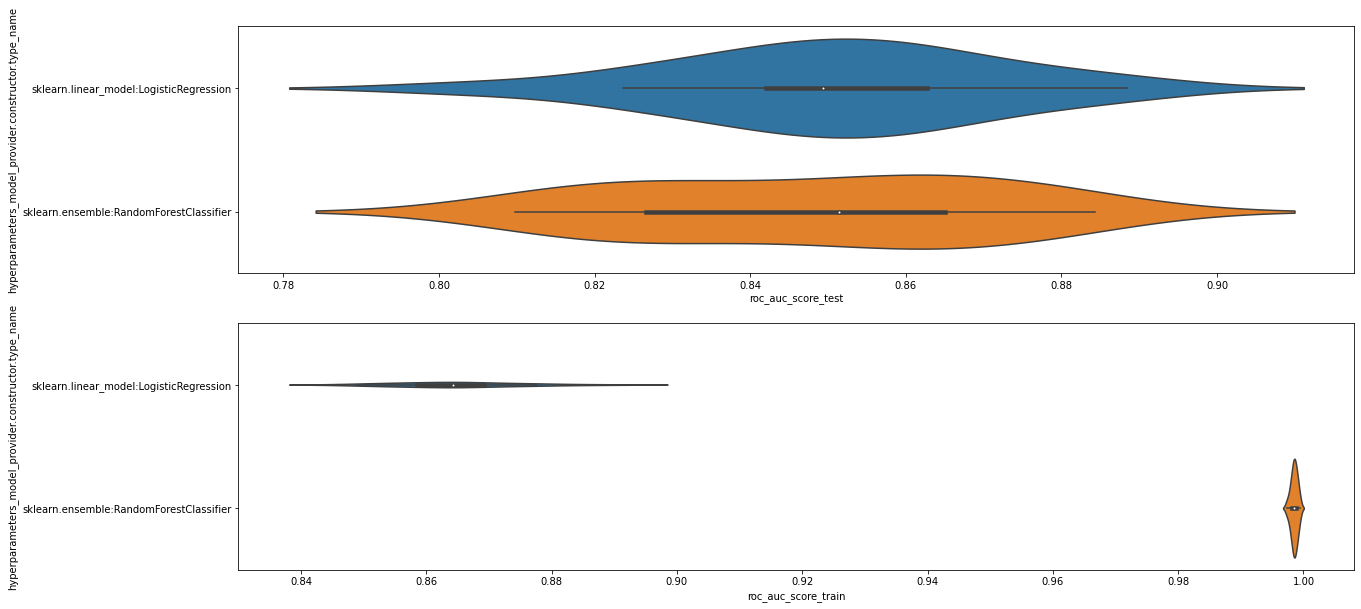

In [26]:
from matplotlib import pyplot as plt
_, ax = plt.subplots(2,1,figsize=(20,10))
violinplot(data=rdf, 
           x='roc_auc_score_test', 
           y='hyperparameters_model_provider.constructor.type_name', 
           orient='horisontal',
           ax=ax[0]
          )
violinplot(data=rdf, 
           x='roc_auc_score_train', 
           y='hyperparameters_model_provider.constructor.type_name', 
           orient='horisontal',
           ax=ax[1])
pass

We see the classic image for logistic regression  and random forest: while they perform comparable on the test set, the random forests fit extremely well on the train set.